# Full unitary solution - extract spt phases
Created 07/07/2024

Objectives:
* Extract spt phases from solved boundary operators.

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../")

In [3]:
import tqdm

In [4]:
from itertools import chain, combinations
from collections import defaultdict
import re

In [5]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import pickle

In [6]:
import numpy as np
import jax.numpy as jnp

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

from matplotlib.ticker import AutoMinorLocator, MultipleLocator

In [7]:
import quimb as qu
import quimb.tensor as qtn

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


# Load data

In [8]:
DATA_DIR = r"../data/transverse_cluster_14_site_ed"

In [9]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [10]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [11]:
psi_dict = dict()

In [12]:
for b in b_parameters:
    tenpy_psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )
    #psi = split_full_state_legs(psi)

    quimb_psi = qtn.Dense1D(
        tenpy_psi.to_ndarray(),
        phys_dim=2
    )
    
    rounded_b = round(b, 1)
    psi_dict[rounded_b] = quimb_psi

## Load boundary operators

In [13]:
SOL_DIR = r"svd_solutions/"

In [14]:
file_name_pattern = re.compile(r'^\d\.\d_\d\.pickle$')

In [15]:
def parse_file_name(file_name):
    if not bool(file_name_pattern.match(file_name)):
        return None

    file_name = '.'.join((file_name.split('.'))[:-1])

    b, sym_index= file_name.split('_')

    b = float(b)
    sym_index = int(sym_index)
    
    return (b, sym_index)

In [16]:
boundary_operator_solutions = dict()

for local_file_name in list(os.walk(SOL_DIR))[0][2]:
    f_name = r"{}/{}".format(SOL_DIR, local_file_name, ignore_unknown=False)

    key = parse_file_name(local_file_name)

    if key is not None:
        with open(f_name, 'rb') as f:
            out = pickle.load(f)
    
            boundary_operator_solutions[key] = out

In [17]:
boundary_operator_solutions[(0.0, 1)]

((Tensor(shape=(16, 16), inds=('b_left', 'k_left'), tags=oset([])),
  Tensor(shape=(16, 16), inds=('b_right', 'k_right'), tags=oset([]))),
 [0.8618978245660459,
  1.0000000000000016,
  1.000000000000002,
  1.0000000000000016,
  1.0000000000000013,
  1.0000000000000016,
  1.000000000000002,
  1.0000000000000018,
  1.0000000000000016,
  1.0000000000000016,
  1.000000000000002,
  1.000000000000002,
  1.0000000000000022,
  1.0000000000000018,
  1.000000000000002,
  1.0000000000000018,
  1.0000000000000016,
  1.0000000000000018,
  1.0000000000000018,
  1.0000000000000016])

### Check values

In [18]:
scores = {k: v[-1][-1] for k, v in boundary_operator_solutions.items()}

In [19]:
pd.Series(scores.values()).describe()

count    63.000000
mean      0.935849
std       0.090923
min       0.575380
25%       0.915870
50%       0.980338
75%       0.993304
max       1.000000
dtype: float64

# Definitions

In [20]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])

In [21]:
symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [22]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [23]:
def generate_problem_rdm(quimb_psi, symmetry_site_pairs, leftmost_symmetry_site,
                         num_symmetry_sites, num_boundary_sites):
    q_top = quimb_psi.copy(deep=True)
    for i, s in symmetry_site_pairs:
        q_top.gate(
            s,
            where=i,
            contract=False,
            inplace=True
        )

    left_boundary_sites = list(range(
        leftmost_symmetry_site-num_boundary_sites,
        leftmost_symmetry_site
    ))

    right_boundary_sites = list(range(
        leftmost_symmetry_site+num_symmetry_sites,
        leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites
    ))
    
    indices_to_map = list(chain(left_boundary_sites, right_boundary_sites))

    index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

    q_bottom = (
        quimb_psi
        .copy()
        .reindex(index_mapping, inplace=True)
        .conj()
    )

    sites_to_contract = {
        'left': list(range(leftmost_symmetry_site-num_boundary_sites)),
        'middle': list(range(leftmost_symmetry_site, leftmost_symmetry_site+num_symmetry_sites)),
        'right': list(range(leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites, quimb_psi.L))
    }

    tags_to_contract = {
        k: [f'I{i}' for i in v]
        for k, v in sites_to_contract.items()
    }

    tn = (q_top & q_bottom)

    """
    tnc = (
        tn
        .contract(tags_to_contract['left'])
        .contract(tags_to_contract['middle'])
        .contract(tags_to_contract['right'])
    )
    """

    tnc = tn.contract()

    fuse_maps = [
        ('k_left', (f'k{i}' for i in left_boundary_sites)),
        ('b_left', (f'b{i}' for i in left_boundary_sites)),
        ('k_right', (f'k{i}' for i in right_boundary_sites)),
        ('b_right', (f'b{i}' for i in right_boundary_sites))
    ]

    tnc.fuse(fuse_maps, inplace=True)

    return tnc

## SPT extraction functions

In [24]:
symmetry_combination_labels = list(combinations(symmetry_labels, 2))

In [25]:
symmetry_combination_labels

[('II', 'IX'),
 ('II', 'XI'),
 ('II', 'XX'),
 ('IX', 'XI'),
 ('IX', 'XX'),
 ('XI', 'XX')]

In [26]:
e, a, b, c = symmetry_labels

In [27]:
group_products = [
    (a, b, c),
    (b, a, c),
    (a, c, b),
    (c, a, b),
    (c, b, a),
    (b, c, a)
]

In [28]:
def relabel_mpo(mpo, k_label, b_label):
    site_locs = [
        int(k[1:]) for k in mpo.tag_map
        if bool(re.search(regex_p, k))
    ]

    k_in_indices = [f'k{i}' for i in site_locs]
    j_in_indices = [f'b{i}' for i in site_locs]

    k_out_indices = [f'{k_label}{i}' for i in site_locs]
    j_out_indices = [f'{b_label}{i}' for i in site_locs]

    mapping = dict(
        chain(
            zip(k_in_indices, k_out_indices),
            zip(j_in_indices, j_out_indices)
        )
    )

    mpo.reindex(mapping, inplace=True)

In [29]:
def get_proj_rep_phase(rho, u_g, u_h, u_gh):
    m = (u_gh.conj().T) @ u_h @ u_g @ rho
    exp = np.trace(m)

    out = exp/np.abs(exp)

    return out

In [30]:
def get_proj_rep_phases(rho, unitaries):
    out = list()

    unitaries_dict = {
        k: v for k, v in zip(symmetry_labels[1:], unitaries)
    }

    out_phases = list()
    for a, b, c in group_products:
        phase = get_proj_rep_phase(
            rho,
            unitaries_dict[a],
            unitaries_dict[b],
            unitaries_dict[c]
        )

        out_phases.append(phase)

    return out_phases

# Extract spt phases

In [31]:
b_params = np.round(np.linspace(0, 2, 21), 3)

In [32]:
num_boundary_sites=4
left_most_symmetry_site=5
leftmost_symmetry_site=left_most_symmetry_site
num_symmetry_sites=4

In [33]:
proj_rep_phases = list()

for t in b_params:
    psi = psi_dict[t]

    rdm = generate_problem_rdm(
        psi,
        [],
        leftmost_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites
    )

    left_rdm = (
        rdm
        .trace('b_right', 'k_right')
        .transpose('k_left', 'b_left')
        .data
    )
    right_rdm = (
        rdm
        .trace('b_left', 'k_left')
        .transpose('k_right', 'b_right')
        .data
    )

    unitary_pairs = [boundary_operator_solutions[(t, i)][0] for i in [1,2,3]]
    left_unitaries, right_unitaries = zip(*unitary_pairs)

    left_unitaries = [
        lu.transpose('b_left', 'k_left').data
        for lu in left_unitaries
    ]

    right_unitaries = [
        ru.transpose('b_right', 'k_right').data
        for ru in right_unitaries
    ]
    left_phases = get_proj_rep_phases(left_rdm, left_unitaries)
    right_phases = get_proj_rep_phases(right_rdm, right_unitaries)

    proj_rep_phases.append([left_phases, right_phases])

In [34]:
proj_rep_phases = np.array(proj_rep_phases)

In [35]:
proj_rep_phases.shape

(21, 2, 6)

In [36]:
b_params

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ])

In [37]:
len(b_params)

21

In [38]:
np.round(
    proj_rep_phases[..., ::2]/proj_rep_phases[..., 1::2],
    2
)

array([[[-1.-0.j, -1.+0.j, -1.-0.j],
        [-1.+0.j, -1.+0.j, -1.+0.j]],

       [[-1.+0.j, -1.+0.j, -1.+0.j],
        [-1.+0.j, -1.-0.j, -1.+0.j]],

       [[-1.+0.j, -1.+0.j, -1.+0.j],
        [-1.+0.j, -1.-0.j, -1.-0.j]],

       [[-1.-0.j, -1.-0.j, -1.-0.j],
        [-1.-0.j, -1.-0.j, -1.+0.j]],

       [[-1.-0.j, -1.-0.j, -1.+0.j],
        [-1.+0.j, -1.+0.j, -1.-0.j]],

       [[-1.+0.j, -1.+0.j, -1.-0.j],
        [-1.+0.j, -1.-0.j, -1.-0.j]],

       [[-1.+0.j, -1.-0.j, -1.+0.j],
        [-1.-0.j, -1.+0.j, -1.+0.j]],

       [[-1.-0.j, -1.-0.j, -1.-0.j],
        [-1.+0.j, -1.+0.j, -1.+0.j]],

       [[ 1.-0.j,  1.-0.j,  1.-0.j],
        [ 1.+0.j,  1.+0.j,  1.-0.j]],

       [[ 1.+0.j,  1.+0.j,  1.+0.j],
        [ 1.+0.j,  1.+0.j,  1.-0.j]],

       [[ 1.+0.j,  1.+0.j,  1.+0.j],
        [ 1.+0.j,  1.+0.j,  1.-0.j]],

       [[ 1.-0.j,  1.-0.j,  1.-0.j],
        [ 1.+0.j,  1.+0.j,  1.-0.j]],

       [[ 1.+0.j,  1.+0.j,  1.+0.j],
        [ 1.+0.j,  1.-0.j,  1.+0.j]],

       [[ 1.

In [39]:
gauge_invariant_proj_rep_phase = proj_rep_phases[..., ::2]/proj_rep_phases[..., 1::2]

In [40]:
np.round(gauge_invariant_proj_rep_phase[:8], 2)

array([[[-1.-0.j, -1.+0.j, -1.-0.j],
        [-1.+0.j, -1.+0.j, -1.+0.j]],

       [[-1.+0.j, -1.+0.j, -1.+0.j],
        [-1.+0.j, -1.-0.j, -1.+0.j]],

       [[-1.+0.j, -1.+0.j, -1.+0.j],
        [-1.+0.j, -1.-0.j, -1.-0.j]],

       [[-1.-0.j, -1.-0.j, -1.-0.j],
        [-1.-0.j, -1.-0.j, -1.+0.j]],

       [[-1.-0.j, -1.-0.j, -1.+0.j],
        [-1.+0.j, -1.+0.j, -1.-0.j]],

       [[-1.+0.j, -1.+0.j, -1.-0.j],
        [-1.+0.j, -1.-0.j, -1.-0.j]],

       [[-1.+0.j, -1.-0.j, -1.+0.j],
        [-1.-0.j, -1.+0.j, -1.+0.j]],

       [[-1.-0.j, -1.-0.j, -1.-0.j],
        [-1.+0.j, -1.+0.j, -1.+0.j]]])

In [41]:
np.round(gauge_invariant_proj_rep_phase[8:], 2)

array([[[1.-0.j, 1.-0.j, 1.-0.j],
        [1.+0.j, 1.+0.j, 1.-0.j]],

       [[1.+0.j, 1.+0.j, 1.+0.j],
        [1.+0.j, 1.+0.j, 1.-0.j]],

       [[1.+0.j, 1.+0.j, 1.+0.j],
        [1.+0.j, 1.+0.j, 1.-0.j]],

       [[1.-0.j, 1.-0.j, 1.-0.j],
        [1.+0.j, 1.+0.j, 1.-0.j]],

       [[1.+0.j, 1.+0.j, 1.+0.j],
        [1.+0.j, 1.-0.j, 1.+0.j]],

       [[1.-0.j, 1.+0.j, 1.-0.j],
        [1.-0.j, 1.-0.j, 1.-0.j]],

       [[1.-0.j, 1.-0.j, 1.+0.j],
        [1.+0.j, 1.+0.j, 1.+0.j]],

       [[1.-0.j, 1.+0.j, 1.-0.j],
        [1.+0.j, 1.+0.j, 1.+0.j]],

       [[1.-0.j, 1.+0.j, 1.-0.j],
        [1.-0.j, 1.-0.j, 1.-0.j]],

       [[1.+0.j, 1.-0.j, 1.-0.j],
        [1.+0.j, 1.+0.j, 1.-0.j]],

       [[1.-0.j, 1.-0.j, 1.+0.j],
        [1.+0.j, 1.+0.j, 1.+0.j]],

       [[1.+0.j, 1.+0.j, 1.+0.j],
        [1.+0.j, 1.+0.j, 1.-0.j]],

       [[1.+0.j, 1.+0.j, 1.-0.j],
        [1.-0.j, 1.+0.j, 1.+0.j]]])

In [42]:
delta_gauge_invariant_proj_rep_phase = gauge_invariant_proj_rep_phase.copy()
delta_gauge_invariant_proj_rep_phase[:8]*=-1

In [43]:
delta_gauge_invariant_proj_rep_angle = np.imag(np.log(delta_gauge_invariant_proj_rep_phase))

In [44]:
delta_gauge_invariant_proj_rep_angle.shape

(21, 2, 3)

In [45]:
markers = ['<', '>']

In [46]:
colors = [
    'tab:blue',
    'tab:orange',
    'tab:green'
]   

In [47]:
e, a, b, c = symmetry_labels

In [48]:
symmetry_pair_labels = [
    a + ',' + b,
    a + ',' + c,
    c + ',' + b
]

In [49]:
side_labels = ['Left', 'Right']

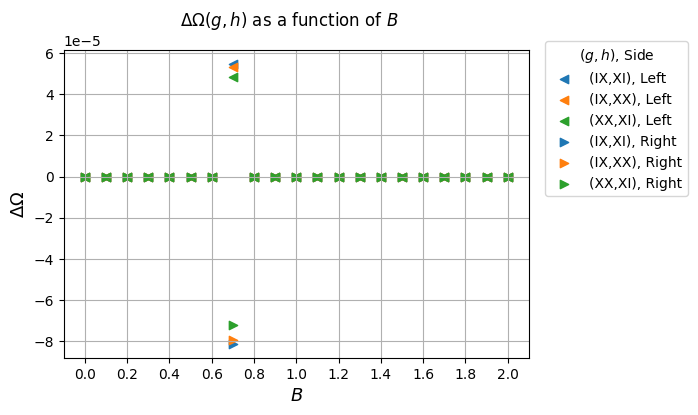

In [50]:
fig, ax = plt.subplots(figsize=(6, 4))

for i, (marker, side_label) in enumerate(zip(markers, side_labels)):
    for j, (col, label) in enumerate(zip(colors, symmetry_pair_labels)):
        plt.scatter(
            b_params,
            delta_gauge_invariant_proj_rep_angle[:, i, j],
            marker=marker,
            color=col,
            label = f'({label}), {side_label}'
        )

ax.xaxis.set_major_locator(
    matplotlib.ticker.MultipleLocator(0.2)
)

ax.grid()

ax.set_ylabel(r'$\Delta \Omega$', fontsize=13)
ax.set_xlabel('$B$', fontsize=13)

ax.legend(bbox_to_anchor=(1.02, 1.05), title='$(g,h)$, Side')

fig.suptitle(r'$\Delta \Omega(g,h)$ as a function of $B$')

fig.savefig(r'plots/ed_delta_proj_rep_angle_from_svd_bosonic.png', dpi=200)

In [51]:
delta_gauge_invariant_proj_rep_angle[7]

array([[ 5.47763924e-05,  5.32954988e-05,  4.84454950e-05],
       [-8.12111059e-05, -7.94218492e-05, -7.21546350e-05]])

In [52]:
np.max(np.abs(np.delete(delta_gauge_invariant_proj_rep_angle, 7, axis=0)))

1.5932102544468887e-15

In [53]:
scores = list()
for t in b_params:

    scores.append([boundary_operator_solutions[(t, i)][1][-1] for i in [1,2,3]])

scores = np.array(scores)

In [54]:
scores.shape

(21, 3)

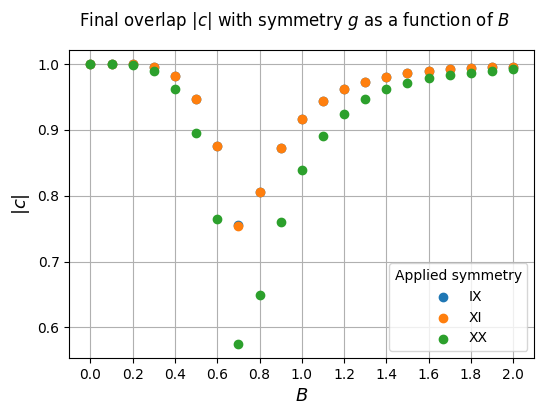

In [55]:
fig, ax = plt.subplots(figsize=(6,4))

for j, (col, label) in enumerate(zip(colors, symmetry_labels[1:])):
    plt.scatter(
        b_params,
        scores[:, j],
        color=col,
        label = label
    )

ax.xaxis.set_major_locator(
    matplotlib.ticker.MultipleLocator(0.2)
)

#ax.set_yscale('log')

ax.grid()
ax.grid(
    which='minor',
    axis='y',
    linestyle='--',
    zorder=-1e10
)
ax.set_axisbelow(True)

ax.set_ylabel(r'$\vert c\vert$', fontsize=13)
ax.set_xlabel('$B$', fontsize=13)

ax.legend(loc='lower right', title='Applied symmetry')

fig.suptitle(r'Final overlap $\vert c \vert$ with symmetry $g$ as a function of $B$')

fig.savefig(r'plots/ed_cost_function_from_svd_bosonic.png', dpi=200)

# Final plot

In [56]:
gauge_invariant_proj_rep_angle = np.imag(np.log(gauge_invariant_proj_rep_phase))
gauge_invariant_proj_rep_angle[gauge_invariant_proj_rep_angle<=-np.pi/2] += 2*np.pi

In [57]:
mean_gauge_invariant_proj_rep_angle = np.mean(gauge_invariant_proj_rep_angle, axis=(1,2))
max_gauge_invariant_proj_rep_angle = np.max(gauge_invariant_proj_rep_angle, axis=(1,2))
min_gauge_invariant_proj_rep_angle = np.min(gauge_invariant_proj_rep_angle, axis=(1,2))

min_max_gauge_invariant_proj_rep_angle = np.stack(
    [
        min_gauge_invariant_proj_rep_angle,
        max_gauge_invariant_proj_rep_angle
    ],
    axis=0
)

error_gauge_invariant_proj_rep_angle = (
    min_max_gauge_invariant_proj_rep_angle
    - mean_gauge_invariant_proj_rep_angle[np.newaxis, :]
)
error_gauge_invariant_proj_rep_angle = np.abs(error_gauge_invariant_proj_rep_angle)

In [58]:
np.max(error_gauge_invariant_proj_rep_angle)

6.84994052999599e-05

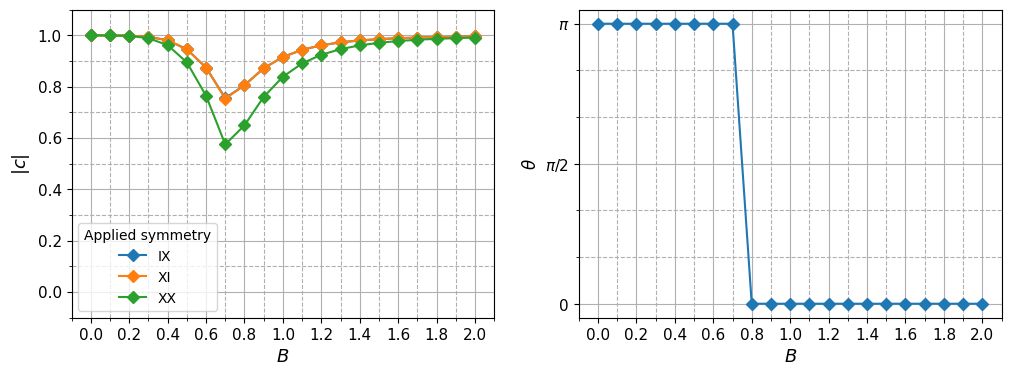

In [59]:
fig, [ax1, ax2] = plt.subplots(figsize=(12, 4), ncols=2)

for i in range(1, 4):
    ax1.plot(
        b_params,
        scores[:, i-1],
        label=symmetry_labels[i],
        marker='D'
    )

ax1.set_ylabel(r'$\vert c \vert$', fontsize=13)
ax1.legend(title='Applied symmetry')
ax1.set_ylim(-0.1, 1.1)
ax1.yaxis.set_major_locator(MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(MultipleLocator(0.1))


ax2.plot(
    b_params,
    mean_gauge_invariant_proj_rep_angle,
    color='tab:blue',
    marker='D'
)

ax2.set_yticks(
    np.linspace(0, np.pi, 3),
    labels=['$0$', '$\pi/2$', '$\pi$']
)

ax2.set_yticks(
    [np.pi/6, np.pi/3, 2*np.pi/3, 5*np.pi/6],
    minor=True
)

ax2.set_ylabel(r'$\theta$', fontsize=12)

for ax in [ax1, ax2]:
    ax.grid()
    ax.xaxis.set_major_locator(MultipleLocator(0.2))
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))

    ax.set_xlabel('$B$', fontsize=13)

    ax.tick_params(
        axis='both',
        which='major',
        labelsize=11
    )

    ax.grid(
        which='minor',
        linestyle='--',
    )

fig.savefig(
    r'plots/unitary_circuit_bosonic_ed_results.png',
    bbox_inches='tight',
    dpi=200
)

In [70]:
with open(r'../make_plots/data/bosonic_results/ed_circuit_b_params.pkl', 'wb') as f:
    pickle.dump(b_params, f)

with open(r'../make_plots/data/bosonic_results/ed_circuit_mean_gauge_invariant_proj_rep_angle.pkl', 'wb') as f:
    pickle.dump(mean_gauge_invariant_proj_rep_angle, f)

with open(r'../make_plots/data/bosonic_results/ed_circuit_overlaps.pkl', 'wb') as f:
    pickle.dump(scores, f)